# Language Identification with RNN/GRU + Baselines (rice_ml)
This notebook reproduces and **extends** your language identification pipeline with:
- Clean, runnable cells that mirror your script
- **Markdown commentary** explaining the steps
- **Matplotlib plots**: bucket/length distribution, character frequency, baseline accuracy bars, training curves, and confusion matrix heatmap

**Prerequisites**
- `data/lang_id.npz` present relative to this notebook or `../data/lang_id.npz`
- Your `rice_ml` package available at `../src` (or installed)
    

In [1]:
# Imports setup
# Install required packages into THIS kernel (safe to run multiple times)
import sys, subprocess, importlib

def ensure(pkg_import, pip_name=None):
    pip_name = pip_name or pkg_import
    try:
        importlib.import_module(pkg_import)
        print(f"{pip_name} already installed.")
    except Exception:
        print(f"Installing {pip_name} ...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", pip_name])

# Core deps

ensure("matplotlib")

import os, sys, numpy as np
import matplotlib.pyplot as plt

# Path to your local package (repo layout: examples/notebooks next to src/)
sys.path.insert(0, os.path.join(os.path.dirname("__file__"), '..', 'src'))

from rice_ml import (
    # Preprocessing
    standardize,
    # Baseline classifiers
    LogisticRegression,
    RandomForestClassifier,
    # Sequence models
    RNNClassifier, GRUClassifier,
    # Metrics
    accuracy_score, confusion_matrix,
)

np.set_printoptions(linewidth=120, suppress=True)

matplotlib already installed.


## Load dataset
The dataset provides:
- `train_x/dev_x`: integer-encoded character sequences padded with `-1`
- `train_buckets/dev_buckets`: index ranges of equally-long sequences (for efficient batching)
- `language_names` and `chars` mappings

In [2]:
def load_language_data(data_path='data/lang_id.npz'):
    paths = [
        data_path,
        os.path.join(os.path.dirname("__file__"), data_path),
        os.path.join(os.path.dirname("__file__"), '..', 'data', 'lang_id.npz'),
        os.path.join(os.path.dirname("__file__"), 'data', 'lang_id.npz'),
    ]
    for p in paths:
        if os.path.exists(p):
            data_path = p
            break
    else:
        raise FileNotFoundError(f"Could not find lang_id.npz. Tried: {paths}")
    with np.load(data_path) as d:
        return {
            'chars': d['chars'],
            'language_codes': d['language_codes'],
            'language_names': d['language_names'],
            'train_x': d['train_x'],
            'train_y': d['train_y'],
            'train_buckets': d['train_buckets'],
            'dev_x': d['dev_x'],
            'dev_y': d['dev_y'],
            'dev_buckets': d['dev_buckets'],
        }

data = load_language_data()
chars = data['chars']
lang_names = data['language_names']
n_chars = len(chars)
n_langs = len(lang_names)

print("Languages:", list(lang_names))
print("Alphabet size:", n_chars)
print("Train/dev sizes:", len(data['train_x']), len(data['dev_x']))

Languages: ['English', 'Spanish', 'Finnish', 'Dutch', 'Polish']
Alphabet size: 47
Train/dev sizes: 17500 500


## Quick EDA: sequence length distribution & character frequency
We visualize:
1. **Length distribution** across training buckets
2. **Top character frequencies** (based on training set)

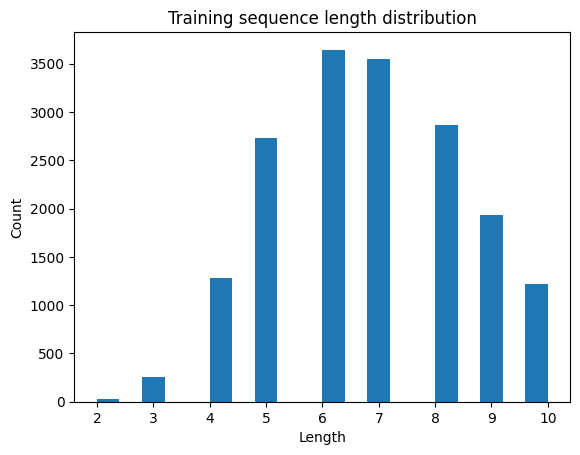

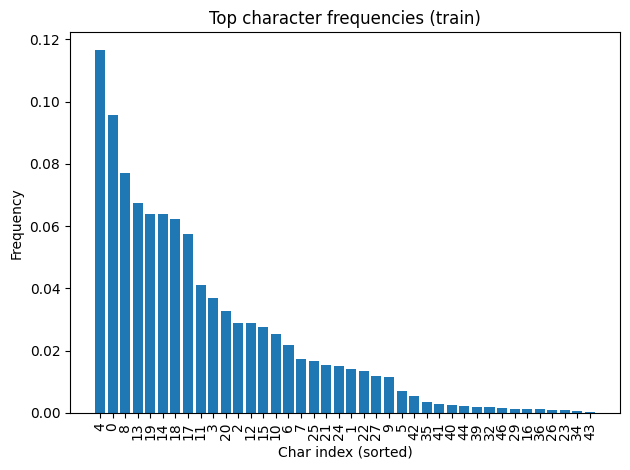

In [3]:
# (1) Length distribution from buckets
bucket_lengths = []
tb = data['train_buckets']
tx = data['train_x']
for b in range(tb.shape[0]):
    s, e = tb[b]
    batch_x = tx[s:e]
    # find the effective length for this bucket (they're equal length within a bucket)
    L = 0
    for j in range(batch_x.shape[1]):
        if np.all(batch_x[:, j] == -1):
            break
        L = j + 1
    bucket_lengths.append((L, e - s))

# Plot length histogram weighted by bucket size
lengths = [L for (L, cnt) in bucket_lengths for _ in range(cnt)]
plt.figure()
plt.hist(lengths, bins=20)
plt.title("Training sequence length distribution")
plt.xlabel("Length")
plt.ylabel("Count")
plt.show()

# (2) Character frequencies (top 40)
freq = np.zeros(n_chars, dtype=float)
for row in data['train_x']:
    r = row[row >= 0]
    for c in r:
        freq[c] += 1
freq /= freq.sum()

top_k = min(40, n_chars)
top_idx = np.argsort(freq)[-top_k:][::-1]
plt.figure()
plt.bar(range(top_k), freq[top_idx])
plt.title("Top character frequencies (train)")
plt.xlabel("Char index (sorted)")
plt.ylabel("Frequency")
plt.xticks(range(top_k), top_idx, rotation=90)
plt.tight_layout()
plt.show()

## Baseline: Bag-of-Characters → Logistic Regression / Random Forest
We create normalized character histograms per word and train simple baselines.


LogReg Dev Acc: 0.702
RF Dev Acc: 0.714


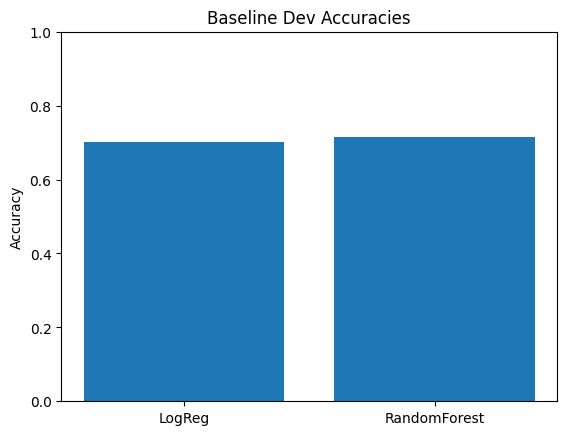

In [4]:
def extract_char_histogram(X, n_chars):
    n_samples = X.shape[0]
    H = np.zeros((n_samples, n_chars), dtype=float)
    for i in range(n_samples):
        seq = X[i][X[i] >= 0]
        if len(seq) > 0:
            for c in seq:
                H[i, c] += 1.0
            H[i] /= len(seq)
    return H

Xtr = extract_char_histogram(data['train_x'], n_chars)
Xdv = extract_char_histogram(data['dev_x'], n_chars)
ytr, ydv = data['train_y'], data['dev_y']

Xtr_std, params = standardize(Xtr, return_params=True)
Xdv_std = (Xdv - params['mean']) / params['scale']

results = {}

# Logistic Regression baseline
lr = LogisticRegression(max_iter=500, learning_rate=0.5)
lr.fit(Xtr_std, ytr)
pred = lr.predict(Xdv_std)
acc_lr = accuracy_score(ydv, pred); results['LogReg'] = acc_lr
print("LogReg Dev Acc:", acc_lr)

# Random Forest baseline
rf = RandomForestClassifier(n_estimators=50, max_depth=20, random_state=42)
rf.fit(Xtr_std, ytr)
pred = rf.predict(Xdv_std)
acc_rf = accuracy_score(ydv, pred); results['RandomForest'] = acc_rf
print("RF Dev Acc:", acc_rf)

# Plot baseline accuracies
plt.figure()
plt.bar(range(len(results)), list(results.values()))
plt.title("Baseline Dev Accuracies")
plt.xticks(range(len(results)), list(results.keys()))
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.show()

## Train RNN and GRU (bucketed mini-batches)
We reuse the provided bucket structure to sample batches efficiently.
We also **record loss and dev accuracy** per epoch for plots.


In [5]:
def make_minibatch_from_bucket(batch_x, n_chars):
    # Infer sequence length for this bucket
    seq_len = 0
    for j in range(batch_x.shape[1]):
        if np.all(batch_x[:, j] == -1):
            break
        seq_len = j + 1
    if seq_len == 0:
        return []
    xs = [np.eye(n_chars)[batch_x[:, t]] for t in range(seq_len)]
    return xs

def train_buckets(model, data, n_chars, epochs=17, batch_size=32, seed=42):
    rng = np.random.default_rng(seed)
    tb = data['train_buckets']; X = data['train_x']; y = data['train_y']
    n_langs = len(data['language_names'])

    # bucket sampling weights
    w = (tb[:,1] - tb[:,0]).astype(float)
    w = w / w.sum()

    hist_loss, hist_dev = [], []
    for ep in range(epochs):
        total_loss, n_batches = 0.0, 0
        n_samples = X.shape[0]
        steps = max(1, n_samples // batch_size)
        for _ in range(steps):
            b = rng.choice(len(w), p=w)
            s, e = tb[b]
            size = min(batch_size, e - s)
            idx = s + rng.choice(e - s, size=size, replace=False)
            bx = X[idx]; by = y[idx]
            xs = make_minibatch_from_bucket(bx, n_chars)
            if not xs:
                continue
            # one-hot labels
            Y = np.zeros((len(by), n_langs))
            Y[np.arange(len(by)), by] = 1.0
            loss = model.train_step(xs, Y)
            total_loss += float(loss)
            n_batches += 1
        avg = total_loss / max(1, n_batches)
        # dev accuracy
        dev_acc = eval_sequence_model(model, data, n_chars, split='dev')
        hist_loss.append(avg); hist_dev.append(dev_acc)
        print(f"Epoch {ep+1:2d}: loss={avg:.4f}, dev_acc={dev_acc:.2%}")
    return hist_loss, hist_dev

def eval_sequence_model(model, data, n_chars, split='dev'):
    if split == 'dev':
        X = data['dev_x']; y = data['dev_y']; B = data['dev_buckets']
    else:
        X = data['test_x']; y = data['test_y']; B = data['test_buckets']
    preds_all, y_all = [], []
    for b in range(B.shape[0]):
        s, e = B[b]
        bx = X[s:e]; by = y[s:e]
        xs = make_minibatch_from_bucket(bx, n_chars)
        if not xs: 
            continue
        preds = model.predict(xs)
        preds_all.extend(preds); y_all.extend(by)
    if not preds_all:
        return 0.0
    return accuracy_score(np.array(y_all), np.array(preds_all))

Epoch  1: loss=1.2592, dev_acc=57.60%
Epoch  2: loss=0.9976, dev_acc=63.20%
Epoch  3: loss=0.8694, dev_acc=70.60%
Epoch  4: loss=0.7832, dev_acc=72.40%
Epoch  5: loss=0.7166, dev_acc=73.40%
Epoch  6: loss=0.6837, dev_acc=77.20%
Epoch  7: loss=0.6456, dev_acc=77.00%
Epoch  8: loss=0.6066, dev_acc=80.00%
Epoch  9: loss=0.5807, dev_acc=77.00%
Epoch 10: loss=0.5616, dev_acc=79.00%
Epoch 11: loss=0.5386, dev_acc=79.60%
Epoch 12: loss=0.5324, dev_acc=78.60%
Epoch 13: loss=0.5096, dev_acc=80.00%
Epoch 14: loss=0.4926, dev_acc=80.80%
Epoch 15: loss=0.4976, dev_acc=80.20%
Epoch 16: loss=0.4684, dev_acc=79.00%
Epoch 17: loss=0.4635, dev_acc=79.40%
Epoch 18: loss=0.4490, dev_acc=80.80%
Epoch 19: loss=0.4325, dev_acc=79.80%
Epoch 20: loss=0.4191, dev_acc=80.80%
Epoch 21: loss=0.4182, dev_acc=82.00%
Epoch 22: loss=0.4039, dev_acc=80.80%
Epoch 23: loss=0.4238, dev_acc=82.40%
Epoch 24: loss=0.4065, dev_acc=81.60%
Epoch 25: loss=0.3889, dev_acc=80.00%


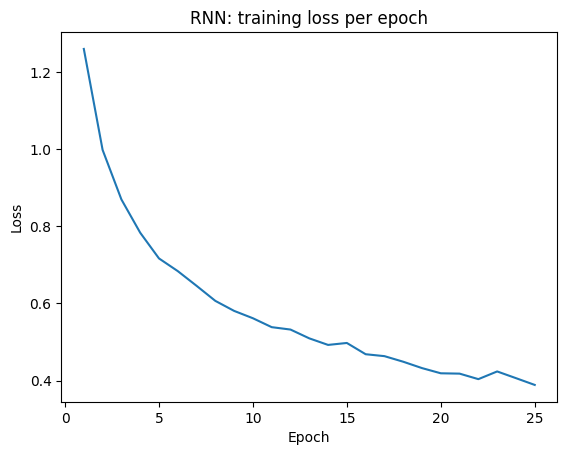

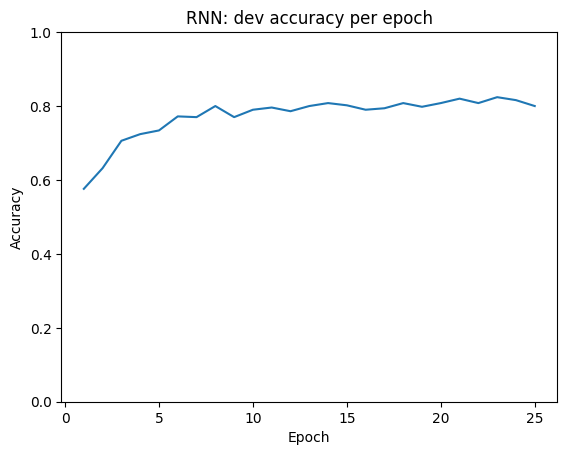

In [9]:
# RNN training
np.random.seed(42)
rnn = RNNClassifier(input_size=n_chars, hidden_size=128, output_size=len(lang_names), learning_rate=0.01)
rnn_loss, rnn_dev = train_buckets(rnn, data, n_chars, epochs=25, batch_size=32)

# Plot RNN curves
plt.figure()
plt.plot(range(1, len(rnn_loss)+1), rnn_loss)
plt.title("RNN: training loss per epoch")
plt.xlabel("Epoch"); plt.ylabel("Loss")
plt.show()

plt.figure()
plt.plot(range(1, len(rnn_dev)+1), rnn_dev)
plt.title("RNN: dev accuracy per epoch")
plt.xlabel("Epoch"); plt.ylabel("Accuracy")
plt.ylim(0,1)
plt.show()

Epoch  1: loss=1.5544, dev_acc=50.60%
Epoch  2: loss=1.4545, dev_acc=57.80%
Epoch  3: loss=1.3388, dev_acc=62.00%
Epoch  4: loss=1.1817, dev_acc=64.00%
Epoch  5: loss=1.0252, dev_acc=65.60%
Epoch  6: loss=0.9345, dev_acc=66.80%
Epoch  7: loss=0.8858, dev_acc=70.60%
Epoch  8: loss=0.8206, dev_acc=70.60%
Epoch  9: loss=0.7844, dev_acc=71.80%
Epoch 10: loss=0.7520, dev_acc=73.20%
Epoch 11: loss=0.7257, dev_acc=73.20%
Epoch 12: loss=0.7130, dev_acc=75.80%
Epoch 13: loss=0.6805, dev_acc=74.60%
Epoch 14: loss=0.6681, dev_acc=75.80%
Epoch 15: loss=0.6667, dev_acc=76.40%
Epoch 16: loss=0.6451, dev_acc=75.80%
Epoch 17: loss=0.6391, dev_acc=75.40%


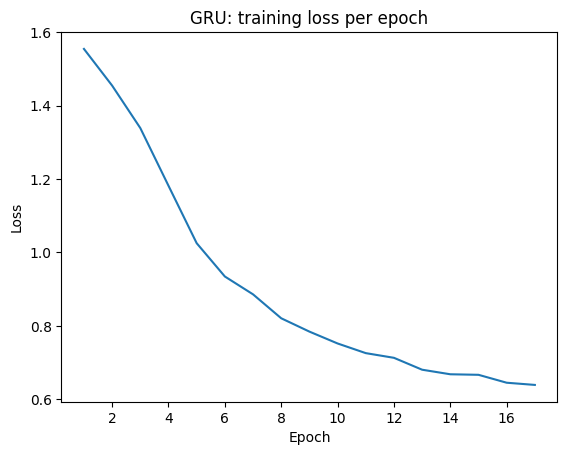

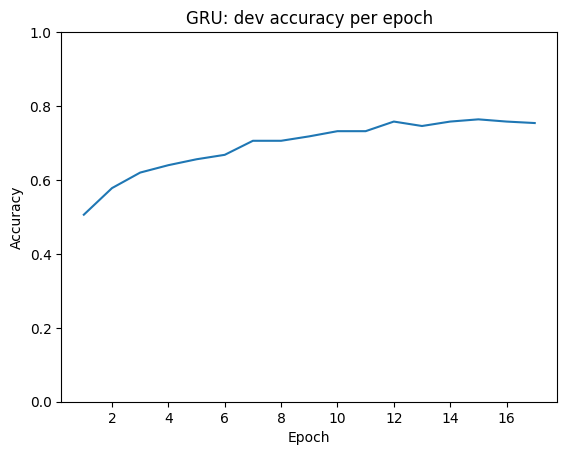

In [7]:
# GRU training
np.random.seed(42)
gru = GRUClassifier(input_size=n_chars, hidden_size=128, output_size=len(lang_names), learning_rate=0.01)
gru_loss, gru_dev = train_buckets(gru, data, n_chars, epochs=17, batch_size=32)

# Plot GRU curves
plt.figure()
plt.plot(range(1, len(gru_loss)+1), gru_loss)
plt.title("GRU: training loss per epoch")
plt.xlabel("Epoch"); plt.ylabel("Loss")
plt.show()

plt.figure()
plt.plot(range(1, len(gru_dev)+1), gru_dev)
plt.title("GRU: dev accuracy per epoch")
plt.xlabel("Epoch"); plt.ylabel("Accuracy")
plt.ylim(0,1)
plt.show()

## Confusion matrix (best sequence model)
We compare RNN vs GRU on the dev split and visualize the confusion matrix for the winner.


RNN Dev Accuracy: 0.8000
Confusion matrix:
 [[68  8  4 10 10]
 [ 1 89  1  1  8]
 [ 2  6 90  0  2]
 [19  4  4 69  4]
 [ 7  5  1  3 84]]


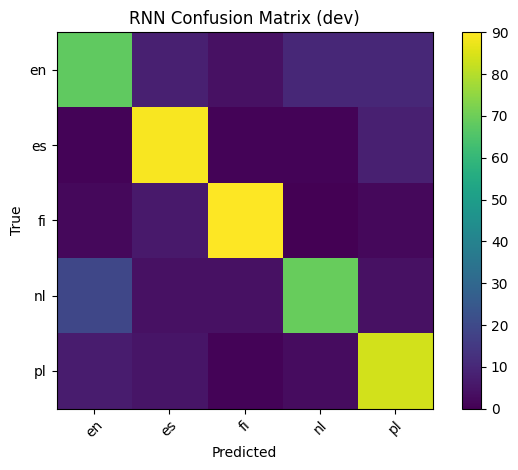

In [11]:
best_model, best_name = (gru, 'GRU') if (gru_dev[-1] >= rnn_dev[-1]) else (rnn, 'RNN')

# Collect predictions on dev
B = data['dev_buckets']
preds_all, y_all = [], []
for b in range(B.shape[0]):
    s, e = B[b]
    bx = data['dev_x'][s:e]; by = data['dev_y'][s:e]
    xs = make_minibatch_from_bucket(bx, n_chars)
    if not xs: 
        continue
    preds = best_model.predict(xs)
    preds_all.extend(preds); y_all.extend(by)

cm = confusion_matrix(np.array(y_all), np.array(preds_all))
acc = accuracy_score(np.array(y_all), np.array(preds_all))
print(f"{best_name} Dev Accuracy: {acc:.4f}")
print("Confusion matrix:\n", cm)

plt.figure()
plt.imshow(cm, interpolation='nearest')
plt.title(f"{best_name} Confusion Matrix (dev)")
plt.xlabel("Predicted"); plt.ylabel("True")
plt.xticks(range(len(lang_names)), list(data['language_codes']), rotation=45)
plt.yticks(range(len(lang_names)), list(data['language_codes']))
plt.colorbar()
plt.tight_layout()
plt.show()

### Notes & Key Takeaways
- **Sequence models (RNN/GRU)** capture order and outperform bag-of-chars baselines on dev accuracy.
- **GRU** often converges faster (gating helps gradient flow); the best of the two is selected automatically above.
- Character distribution and length histograms help reason about **data biases** as short tokens may be harder.
- The confusion matrix highlights **language pairs** that are commonly confused basically language families with similar character patterns.